In [53]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter

from biobank_olink.constants import PROJECT_DATA

targets = ["SBP", "DBP", "PP"]
study_name_template = "two_extremes_{}_xgb_th0.35_corr0.9_s42.csv"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


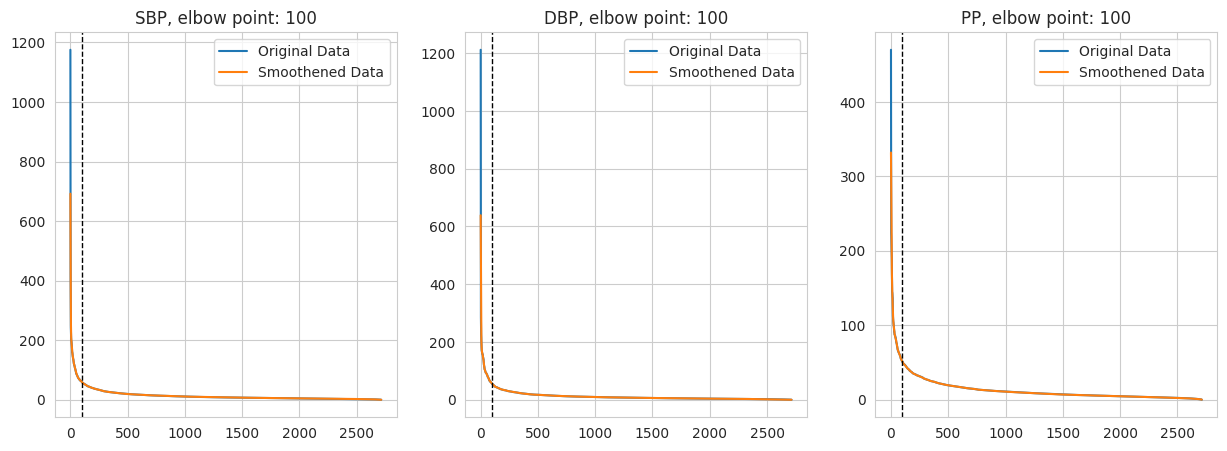

In [54]:
plt.figure(figsize=(15, 5))
selected_features = {}
for i, target in enumerate(targets, 1):
    plt.subplot(1, 3, i)

    study_name = study_name_template.format(target.lower())
    feat_imps = pd.read_csv(PROJECT_DATA / "feat_importances" / study_name).shap_importance
    feat_imps = feat_imps.sort_values(ascending=False)

    y = feat_imps.values.reshape(-1)
    y_fit = gaussian_filter(y, sigma=2)

    first_derivative = np.gradient(y_fit)
    second_derivative = np.gradient(first_derivative)
    curvature = second_derivative / np.power((1 + first_derivative ** 2), 3 / 2)
    elbow_point = np.argmax(curvature)
    
    elbow_point = 100

    selected_features[target] = feat_imps.index[:elbow_point].values

    x = np.arange(len(y))
    plt.plot(x, y, label='Original Data')
    plt.plot(x, y_fit, label='Smoothened Data')
    plt.axvline(x=elbow_point, color='k', linestyle='--', lw=1)
    plt.title(f"{target}, elbow point: {elbow_point}")
    plt.legend()

In [72]:
dfs = {}
cols = ["olink", "shap_importance", "shap_importance_rank", "panel", "correlates_with (corr>0.8)"]
for i, target in enumerate(targets, 1):
    study_name = study_name_template.format(target.lower())
    index = selected_features[target]
    df = pd.read_csv(PROJECT_DATA / "feat_importances" / study_name, index_col=0).iloc[index].reset_index()
    df.rename(columns={"index": "olink"}, inplace=True)
    dfs[target] = df[cols]
pd.concat(dfs, axis=1).to_excel(PROJECT_DATA / "two_extremes_top100_feat_data_ext.xlsx")